# DNN Model (multiple) for shifted MIT data
As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: MinMax Scaler

If you don't have the original files: run the notebook 'preprocessing_mit_binary_shift_minmax_oversampling.ipynb'
Input file: (The preprocessed data)   
mitbih_train_clean_minmax_oversampling.csv   
mitbih_test_clean_minmax_oversampling.csv

Output: DNN model trained  
model_mit_multiple_shift_dnn.h5


In [76]:
import sys
import os

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q
    !pip install matplotlib -q
    !pip install seaborn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive.
    data_path = '/content/drive/MyDrive/data/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data


In [77]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  
import matplotlib.pyplot as plt
import seaborn as sns

RawFiles = dict({
    'train': data_path + 'mitbih_binary_train_shift_minmax_oversampling.csv',
    'test': data_path + 'mitbih_binary_test_shift_minmax_oversampling.csv'
})


OutputFiles = dict({
    'model': model_output_path +  'model_mit_multiple_shift_dnn' 
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [78]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Check the shape
print("X_train shape:", X_train.shape)  # Should be (num_samples, num_features)
print("X_test shape:", X_test.shape)    # Should be (num_samples, num_features)


X_train shape: (144942, 187)
X_test shape: (20284, 187)


In [79]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)


# DNN with MinMax Scaler and Oversampling

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU
import numpy as np
import random

# Seed 
seed = 42
np.random.seed(seed) # Seed for NumPy
tf.random.set_seed(seed) # Seed for TensorFlow
random.seed(seed) # Seed for Python


# Define the model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train.shape[1],)))  # Explicitly define the input shape

# First Dense Layer
model.add(Dense(187, activation='relu'))
model.add(BatchNormalization())

# Subsequent Layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(5, activation='softmax')) # 5 classes for the target variable

# Compile the Model
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
#model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])


model.summary()

# Callbacks: EarlyStopping 
early_stopping = EarlyStopping(
    monitor='val_loss',   # value that will be monitored  
    min_delta=0.01,       # minimium amount of change to count as an improvement    
    patience=10,          # how many epochs to wait before stopping    
    verbose=1,            # print additional information like the epoch number
    mode='min',           # direction of improvement to stop training
    restore_best_weights=True # restore the best weights when stopping
)

# ReduceLROnPlateau
reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",  # value that will be monitored     
    min_delta=0.01,      # minimium amount of change to count as an improvement     
    patience=3,          # how many epochs to wait before stopping     
    factor=0.1,          # factor by which the learning rate will be reduced   
    cooldown=4,          # number of epochs to wait before resuming normal operation after lr has been reduced     
    verbose=1            # print additional information like the epoch number     
)

# Train Modell
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_learning_rate],
    verbose=1
)

# Train Scores
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f"Final Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
      f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Prediction
y_pred = model.predict(X_test)


from sklearn.metrics import roc_curve

# Compute ROC curve for each class
for i in range(y_test.shape[1]):  # Loop over each class
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    print(f"Class {i}: Optimal Threshold = {thresholds[np.argmax(tpr - fpr)]:.2f}")




Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 187)            │        35,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 187)            │           748 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 64)             │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,741 (198.21 KB)

 Trainable params: 50,159 (195.93 KB)

 Non-trainable params: 582 (2.27 KB)

Epoch 1/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - AUC: 0.8874 - accuracy: 0.6717 - loss: 0.8892 - val_AUC: 0.9937 - val_accuracy: 0.9335 - val_loss: 0.2107 - learning_rate: 0.0010
Epoch 2/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9864 - accuracy: 0.8946 - loss: 0.2932 - val_AUC: 0.9969 - val_accuracy: 0.9580 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 3/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9900 - accuracy: 0.9157 - loss: 0.2453 - val_AUC: 0.9960 - val_accuracy: 0.9512 - val_loss: 0.1508 - learning_rate: 0.0010
Epoch 4/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9918 - accuracy: 0.9248 - loss: 0.2183 - val_AUC: 0.9975 - val_accuracy: 0.9619 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 5/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9930 - accuracy: 0.9319 - loss: 0.1992 - val_AUC: 0.9976 - val_accuracy: 0.9656 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 6/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


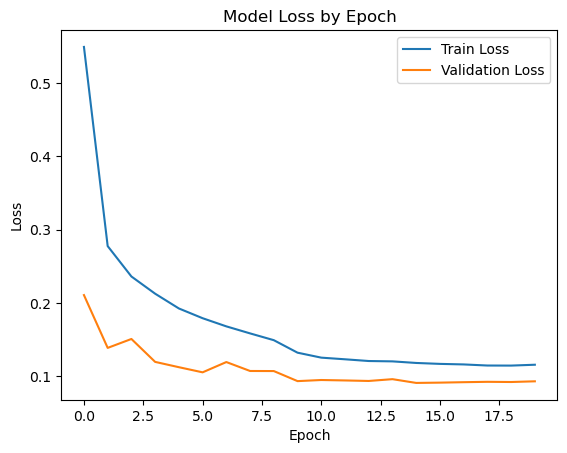

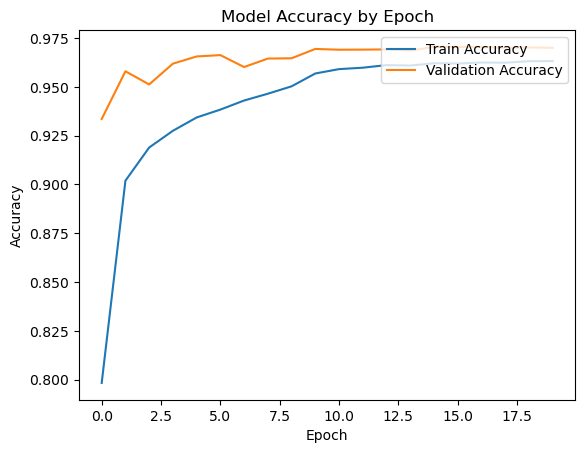

634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


In [81]:
import matplotlib.pyplot as plt

# Plotting the Loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)



In [82]:
# Convert probabilities to class predictions
y_pred_class = np.argmax(y_pred, axis=1)

# Convert one-hot encoded `y_test` to class labels
y_test_class = np.argmax(y_test, axis=1)

In [83]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_class))

# F1 Score
print(f"F1 Score: {f1_score(y_test_class, y_pred_class):.4f}")

Confusion Matrix:
 [[17645   473]
 [  147  2019]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.81      0.93      0.87      2166

    accuracy                           0.97     20284
   macro avg       0.90      0.95      0.92     20284
weighted avg       0.97      0.97      0.97     20284

F1 Score: 0.8669


# Save model

In [84]:
# Save the model in HDF5 format
model_path = OutputFiles.get('model') + '.h5'  # Append .h5 extension
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/model_mit_multiple_shift_dnn.h5


In [85]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-09 15:50:28.335341
